### Coursework coding instructions (please also see full coursework spec)

Please choose if you want to do either Task 1 or Task 2. You should write your report about one task only.

For the task you choose you will need to do two approaches:
  - Approach 1, which can use use pre-trained embeddings / models
  - Approach 2, which should not use any pre-trained embeddings or models
We should be able to run both approaches from the same colab file

#### Running your code:
  - Your models should run automatically when running your colab file without further intervention
  - For each task you should automatically output the performance of both models
  - Your code should automatically download any libraries required

#### Structure of your code:
  - You are expected to use the 'train', 'eval' and 'model_performance' functions, although you may edit these as required
  - Otherwise there are no restrictions on what you can do in your code

#### Documentation:
  - You are expected to produce a .README file summarising how you have approached both tasks

#### Reproducibility:
  - Your .README file should explain how to replicate the different experiments mentioned in your report

Good luck! We are really looking forward to seeing your reports and your model code!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Ion: from now on, its as if running everything from the cmd on: /content/drive

Mounted at /content/drive


In [ ]:
# You will need to download any word embeddings required for your code, e.g.:

# Ion: The below zip file is downloaded and unzipped in /content/drive
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

# For any packages that Colab does not provide auotmatically you will also need to install these below, e.g.:
#! pip install torch

--2021-03-02 15:00:23--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-03-02 15:00:24--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-03-02 15:00:24--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
# Ion: Inspecting the glove files

with open("glove.6B.200d.txt", "r") as f:

  num_lines_to_print = 3
  line_idx = 1

  for line in f:
    print("line: ", line_idx, "\n")
    print(line.strip(), "\n")
    print("type: ", type(line))
    print("length: ", len(line), 2*"\n", 80*"-", "\n")

    line_idx += 1

    if line_idx > num_lines_to_print:
      break

# Ion: Each line in the glove txt docs is a string like:
# "token_represented    first_val_of_vec_embedding    second_val_of_vec_embedding..."
# 50d etc. represents the dim of the embedding

line:  1 

the -0.071549 0.093459 0.023738 -0.090339 0.056123 0.32547 -0.39796 -0.092139 0.061181 -0.1895 0.13061 0.14349 0.011479 0.38158 0.5403 -0.14088 0.24315 0.23036 -0.55339 0.048154 0.45662 3.2338 0.020199 0.049019 -0.014132 0.076017 -0.11527 0.2006 -0.077657 0.24328 0.16368 -0.34118 -0.06607 0.10152 0.038232 -0.17668 -0.88153 -0.33895 -0.035481 -0.55095 -0.016899 -0.43982 0.039004 0.40447 -0.2588 0.64594 0.26641 0.28009 -0.024625 0.63302 -0.317 0.10271 0.30886 0.097792 -0.38227 0.086552 0.047075 0.23511 -0.32127 -0.28538 0.1667 -0.0049707 -0.62714 -0.24904 0.29713 0.14379 -0.12325 -0.058178 -0.001029 -0.082126 0.36935 -0.00058442 0.34286 0.28426 -0.068599 0.65747 -0.029087 0.16184 0.073672 -0.30343 0.095733 -0.5286 -0.22898 0.064079 0.015218 0.34921 -0.4396 -0.43983 0.77515 -0.87767 -0.087504 0.39598 0.62362 -0.26211 -0.30539 -0.022964 0.30567 0.06766 0.15383 -0.11211 -0.09154 0.082562 0.16897 -0.032952 -0.28775 -0.2232 -0.090426 1.2407 -0.18244 -0.0075219 -0.041388 -0.011083 0

In [ ]:
# Imports

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import Dataset, random_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import codecs
import re

pd.options.display.max_columns = None

In [ ]:
# Setting random seed and device
SEED = 1

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [ ]:
# Ion: Loading the original training data
train_df1 = pd.read_csv('drive/MyDrive/data/task-1/train.csv')
# Ion: Loading the secondary training data
train_df2= pd.read_csv('drive/MyDrive/NLP_data/funlines.csv')

# Ion: Combining the two training datasets into one
train_df=pd.concat([train_df1,train_df2])
train_df = train_df.reset_index(drop=True)

# Ion: Loading the original test data
test_df = pd.read_csv('drive/MyDrive/data/task-1/dev.csv')

In [ ]:
# Ion: Inspecting the data

print("Training data: \n")

pd.set_option('display.max_colwidth', 50)
with pd.option_context('expand_frame_repr', False):
  print(train_df)

print()
print(100*"-")
print()

print("Test data: \n")
with pd.option_context('expand_frame_repr', False):
  print(test_df)

Training data: 

           id                                           original        edit  grades  meanGrade
0       14530  France is ‘ hunting down its citizens who join...       twins   10000        0.2
1       13034  Pentagon claims 2,000 % increase in Russian tr...     bowling   33110        1.6
2        8731  Iceland PM Calls Snap Vote as Pedophile Furor ...       party   22100        1.0
3          76  In an apparent first , Iran and Israel <engage...        slap   20000        0.4
4        6164  Trump was told weeks ago that Flynn misled <Vi...      school       0        0.0
...       ...                                                ...         ...     ...        ...
17895  108243  Banning Facial <Recognition/> Is n’t Enough - ...   Cleansers   22222        2.0
17896  108244  Trump is reportedly threatening <Republicans/>...    children   21100        0.8
17897  108245  Peruvian indigenous group wins suit to block o...       Women   22110        1.2
17898  108246  Joe Roga

In [ ]:
# Ion: Changing the replaced words with their substitutes

# Ion: Find the word to be replaced
train_df['old'] = train_df.apply(lambda x:x['original'][x['original'].find('<')+1:x['original'].find('>')-1],axis=1)
test_df['old'] = test_df.apply(lambda x:x['original'][x['original'].find('<')+1:x['original'].find('>')-1],axis=1)

#Replace edited words:
train_df['edited_headlines'] = train_df.apply(lambda x:x['original'].replace(x['original'][x['original'].find('<'):x['original'].find('>')+1],x['edit']) ,axis=1)
test_df['edited_headlines'] = test_df.apply(lambda x:x['original'].replace(x['original'][x['original'].find('<'):x['original'].find('>')+1],x['edit']) ,axis=1)

# Ion: Create a column containing the unedited headlines without <> around the word to be edited out
train_df['unedited_headlines'] = train_df.apply(lambda x:x['original'].replace(x['original'][x['original'].find('<'):x['original'].find('>')+1],x['old']) ,axis=1)
test_df['unedited_headlines'] = test_df.apply(lambda x:x['original'].replace(x['original'][x['original'].find('<'):x['original'].find('>')+1],x['old']) ,axis=1)

# Ion: Create a column containing the edited headlines with the replaced word without <> around it stuck to their end
train_df['edited_headlines_plus_old'] = train_df.apply(lambda x:x['edited_headlines'] + " " + x['old'] ,axis=1)
test_df['edited_headlines_plus_old'] = test_df.apply(lambda x:x['edited_headlines'] + " " + x['old'] ,axis=1)

# Ion: Create a column containing a sequence of just two words: the replaced word and its replacement
train_df['old_edit'] = train_df.apply(lambda x:x['old'] + " " + x['edit'] ,axis=1)
test_df['old_edit'] = test_df.apply(lambda x:x['old'] + " " + x['edit'] ,axis=1)



In [ ]:
# Ion: Inspecting the dataset after replacements

print("Training data: \n")
with pd.option_context('expand_frame_repr', False):
  print(train_df)

print(100*"-")
print()
print("Training Headlines post replacement:")
print()
pd.set_option('display.max_colwidth', -1)
print(train_df["edited_headlines"])
pd.set_option('display.max_colwidth', 50)

print(100*"-")
print()
print("Training Headlines prior to replacement:")
print()
pd.set_option('display.max_colwidth', -1)
print(train_df["unedited_headlines"])
pd.set_option('display.max_colwidth', 50)

print(100*"-")
print()
print("Training Headlines post to replacement with old word at end:")
print()
pd.set_option('display.max_colwidth', -1)
print(train_df["edited_headlines_plus_old"])
pd.set_option('display.max_colwidth', 50)

print()
print(100*"-")
print()

print("Test data: \n")
with pd.option_context('expand_frame_repr', False):
  print(test_df)

print(100*"-")
print()
print("Test Headlines post replacement:")
print()
pd.set_option('display.max_colwidth', -1)
print(test_df["edited_headlines"])
pd.set_option('display.max_colwidth', 50)

print(100*"-")
print()
print("Test Headlines prior to replacement:")
print()
pd.set_option('display.max_colwidth', -1)
print(test_df["unedited_headlines"])
pd.set_option('display.max_colwidth', 50)

print(100*"-")
print()
print("Test Headlines post to replacement with old word at end:")
print()
pd.set_option('display.max_colwidth', -1)
print(train_df["edited_headlines_plus_old"])
pd.set_option('display.max_colwidth', 50)

print()
print(100*"-")
print()

Training data: 

           id                                           original        edit  grades  meanGrade             old                                   edited_headlines                                 unedited_headlines                          edited_headlines_plus_old                   old_edit
0       14530  France is ‘ hunting down its citizens who join...       twins   10000        0.2            Isis  France is ‘ hunting down its citizens who join...  France is ‘ hunting down its citizens who join...  France is ‘ hunting down its citizens who join...                 Isis twins
1       13034  Pentagon claims 2,000 % increase in Russian tr...     bowling   33110        1.6           Syria  Pentagon claims 2,000 % increase in Russian tr...  Pentagon claims 2,000 % increase in Russian tr...  Pentagon claims 2,000 % increase in Russian tr...              Syria bowling
2        8731  Iceland PM Calls Snap Vote as Pedophile Furor ...       party   22100        1.0       Coali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
/usr/local/lib/python3

In [ ]:
# Proportion of training data for train compared to dev
train_proportion = 0.8

In [ ]:
# We define our training loop
def train(train_iter, dev_iter, model, number_epoch, optimizer, loss_fn, print_on=True):
    """
    Training loop for the model, which calls on eval to evaluate after each epoch

    Ion: params: train_iter: A data loader, specifying batch size for the training data
                 dev_iter: A data loader, specifying batch size for the validation data
                 model: Our regressor to be trained
                 number_epoch: Integer giving the number of epochs of training
    """

    print("Training model.")

    # Ion: Each epoch is one pass over the training data
    for epoch in range(1, number_epoch+1):

        model.train()
        epoch_loss = 0
        epoch_sse = 0  # Ion: sse = sum squared error
        no_observations = 0  # Observations used for training so far

        for batch in train_iter:
            
            # Ion: feature.shape = (batch_size x len_padded_headline)
            # Ion: target.shape = (batch_size)
            feature, target = batch
            feature, target = feature.to(device), target.to(device)

            # for RNN:
            model.batch_size = target.shape[0]
            no_observations += target.shape[0]
            model.hidden = model.init_hidden()

            # Ion: predictions.shape = (batch_size)
            predictions = model(feature).squeeze(1)

            optimizer.zero_grad()

            # Ion: example_loss = tensor(1.2081, grad_fn=<MseLossBackward>)
            loss = loss_fn(predictions, target)

            # Ion: sse = sum_over_batch(sq_error) where: sq_error = (output - target)**2
            sse, __ = model_performance(predictions.detach().cpu().numpy(), target.detach().cpu().numpy())

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse

        # Ion: both valid_loss and valid_mse are just float numbers
        valid_loss, valid_mse, __, __ = eval(dev_iter, model, loss_fn)

        # Ion: All the losses/sses that we are printing here are averaged per sample
        epoch_loss, epoch_mse = epoch_loss / no_observations, epoch_sse / no_observations
        if print_on:
          print(f'| Epoch: {epoch:02} | Train Loss: {epoch_loss:.2f} | Train MSE: {epoch_mse:.2f} | Train RMSE: {epoch_mse**0.5:.2f} | \
          Val. Loss: {valid_loss:.2f} | Val. MSE: {valid_mse:.2f} |  Val. RMSE: {valid_mse**0.5:.2f} |')
    return valid_mse**0.5

In [ ]:
# We evaluate performance on our dev set
def eval(data_iter, model, loss_fn):
    """
    Evaluating model performance on the dev set

    Ion: params: dev_iter: A data loader, specifying batch size for the validation data
                 model: Our regressor to be trained
    """

    model.eval()
    epoch_loss = 0
    epoch_sse = 0
    pred_all = []
    trg_all = []
    no_observations = 0

    with torch.no_grad():
        for batch in data_iter:
            feature, target = batch

            feature, target = feature.to(device), target.to(device)

            # for RNN:
            model.batch_size = target.shape[0]
            no_observations = no_observations + target.shape[0]
            model.hidden = model.init_hidden()

            predictions = model(feature).squeeze(1)

            # Ion: Remember the loss is MSE
            loss = loss_fn(predictions, target)

            # Ion: We get the sse (and drop the mse as we already have it, it's the loss above) for the current batch.
            pred, trg = predictions.detach().cpu().numpy(), target.detach().cpu().numpy()
            sse, __ = model_performance(pred, trg)

            epoch_loss += loss.item()*target.shape[0]
            epoch_sse += sse
            pred_all.extend(pred)
            trg_all.extend(trg)

    return epoch_loss/no_observations, epoch_sse/no_observations, np.array(pred_all), np.array(trg_all)

In [ ]:
# How we print the model performance
def model_performance(output, target, print_output=False):
    """
    Returns SSE and MSE per batch (printing the MSE and the RMSE)

    Ion: params: output: torch tensor of shape (batch_size) containing funniness scores output from model.
                 target: torch tensor of shape (batch_size) containing target funniness scores.
    """

    sq_error = (output - target)**2

    sse = np.sum(sq_error)
    mse = np.mean(sq_error)
    rmse = np.sqrt(mse)

    if print_output:
        print(f'| MSE: {mse:.2f} | RMSE: {rmse:.2f} |')

    return sse, mse

In [ ]:
def create_vocab(data):
    """
    Creating a corpus of all the tokens appearing in data

    Ion: params: data: a column of the full dataframe constituting a dataframe where currently
                       each row is a an original title, before any changes
    """

    tokenized_corpus= [] # Let us put the tokenized corpus in a list
    
    stop_word_list = ['the', 'a', 'an', 'that', 'is', 'and', 'or', '‘','.',',','’',':',';','-', '', '\'']

    for sentence in data:
        tokenized_sentence = []
        #tokenized_sentence_PR = re.split(re_punctuation_string, sentence)
        #tokenized_sentence_PR = list(filter(None, tokenized_sentence_PR))

        # Ion: Split sentence into list of words
        split_sentence1 = sentence.split(' ')
        # Ion: Split into two words like "alt-right"
        split_sentence2 = [token for word_with_hyphens in split_sentence1 for token in word_with_hyphens.split("-")]

        for token in split_sentence2:  #simplest split is
            # our code
            token = token.lower()

            if token not in stop_word_list:

              tokenized_sentence.append(token)
        
        
        tokenized_corpus.append(tokenized_sentence)

    # Create single list of all vocabulary

    vocabulary = []  # Let us put all the tokens (mostly words) appearing in the vocabulary in a list
                     # Ion: Not sure what's better, but I would put them in a set. We can check what is common prectice.

    for sentence in tokenized_corpus:

        for token in sentence:

            if token not in vocabulary:

                if True:
                    vocabulary.append(token)

    return vocabulary, tokenized_corpus

In [ ]:
def collate_fn_padd(batch):
    '''
    We add padding to our minibatches and create tensors for our model

    Ion: params: batch: A list of length batch_size of tuples. Each tuple contains a list of indexes referring
                        to words in a headline and a float constituting the funniness score of that headline.
    '''

    # Ion: batch_features is a list of batch_size lists, each inner list containing indexes referring to words in a headline.
    #      batch_features.shape = (batch_size x ~24)
    # Ion: batch_labels is a list of length batch_size, containing scores of funniness of headlines.
    #      batch_labels.shape = (batch_size)
    batch_features = [f for f, l in batch]
    batch_labels = [l for f, l in batch]

    # Ion: 1) Padding batch_features with zeros so that each headline is represented 
    #         by a list of indexes as long as the longest headline in the batch.
    #      2) Conveerting the features and the labels to torch tensors.
    batch_features_len = [len(f) for f, l in batch]
    seq_tensor = torch.zeros((len(batch), max(batch_features_len))).long()
    for idx, (seq, seqlen) in enumerate(zip(batch_features, batch_features_len)):
        seq_tensor[idx, :seqlen] = torch.LongTensor(seq)
    batch_labels = torch.FloatTensor(batch_labels)

    return seq_tensor, batch_labels


class Task1Dataset(Dataset):
    """
    Ion: A class destined to organise together training features and labels and provide methods to handle them.

         params: train_data: A list of length = total_num_training_samples of lists of unpadded integer sequences
                             representing headlines.
                 labels: The col (of length total_num_training_samples) containing funniness scores from the initial
                         training dataframe.
    """

    def __init__(self, train_data, labels):
        self.x_train = train_data
        self.y_train = labels

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, item):
        return self.x_train[item], self.y_train[item]


class Task1Dataset2(Dataset):
    """
    Ion: A class destined to organise together training features and labels and provide methods to handle them.

         params: train_data: A list of length = total_num_training_samples of lists of unpadded integer sequences
                             representing headlines.
                 
    """

    def __init__(self, train_data):
        self.x_train = train_data

    def __len__(self):
        return len(self.x_train)

    def __getitem__(self, item):
        return self.x_train[item]

In [ ]:
def collate_fn_padd_no_labels(batch):
    '''
    We add padding to our minibatches and create tensors for our model

    Ion: params: batch: A list of length batch_size. Each element in the list is a list of indexes referring
                        to words in a headline.
    '''

    # Ion: 1) Padding batch_features with zeros so that each headline is represented 
    #         by a list of indexes as long as the longest headline in the batch.
    #      2) Conveerting the features to torch tensors.
    batch_features_len = [len(f) for f in batch]
    seq_tensor = torch.zeros((len(batch), max(batch_features_len))).long()
    for idx, (seq, seqlen) in enumerate(zip(batch, batch_features_len)):
        seq_tensor[idx, :seqlen] = torch.LongTensor(seq)

    return seq_tensor

In [ ]:
class BiLSTM(nn.Module):
    """
    Ion: Bidirectional LSTM class. Assumes one layer.

         params: embedding_dim: integer length of embedding vector representing each token in a sequence (aka headline).
                 hidden_dim: integer length of hidden state vectors in the LSTM
                 vocab_size: integer number of tokens in vocabulary
                 batch_size: integer size of batch (i.e. number of headlines in each batch)
                 device: device to which the model should be registered. (CPU or CUDA)
    """

    def __init__(self, embedding_dim, hidden_dim, vocab_size, batch_size, device):
        super(BiLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.device = device
        self.batch_size = batch_size

        # Ion: Creates random embeddings of size embedding_dim for all words in the vocabulary
        #      and a look-up table between a word's index in the vocab and its embedding.
        #      Here, pre-trained embeddings from either glove or Word2Vec are to be copied in 
        #      for these random embeddings.
        #      I believe that these embeddings are also trained during training but we need to verify.
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        # Ion: Since here we are using pret-trained embeddings, we do not want our embedding to be training.
        self.embedding.weight.requires_grad = False

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)

        # The linear layer that maps from hidden state space to tag space - Ion: (tag space = label = funniness score)
        self.hidden2label = nn.Linear(hidden_dim * 2, 1)

        # Ion: Initialises hidden state and cell state vectors as torch tensors of zeros for all samples in the batch.
        #      self.hidden.shape = (2, batch_size, hidden_dim)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly why they have this dimensionality.
        # The axes semantics are (num_layers * num_directions, minibatch_size, hidden_dim)
        # Ion: num_layers from right above refers to how many LSTMs we have stacked together. Here only 1.
        #      The 2 refers to the num_directions as this is a bidirectional LSTM.
        return torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device), \
               torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device)

    def forward(self, batch_of_headlines):
        # Ion: Takes us from: batch_of_headlines (batch_size x length_padded_headline) where each headline
        #                     is represented by a list of integer indices of tokens in the vocab padded by 
        #                     zeros to match the length of longest headline in the batch
        #                 to: embedded (batch_size x length_padded_headline x embedding_dim)
        #                     where each headline is represented by a padded list of embeddings.
        embedded = self.embedding(batch_of_headlines)

        # Ion: swaps dims to give embedded.shape = (length_padded_headline x batch_size x embedding_dim)
        embedded = embedded.permute(1, 0, 2)

        # Ion: lstm_out.shape = (length_padded_headline x batch_size x 2*hidden_dim)
        #      lstm_out = A batch of hidden state vectors output from each token in each headline in each batch
        #                 i.e. hidden state vectorrs from different times (each token in sequence is a time instance)
        #                 This is to be used to predict scores of current headlines
        #      self.hidden.shape = (2, batch_size, hidden_dim)
        #      self.hidden = a batch of hidden state vectors output from the last token in each headline in each batch
        #                    This is to be used as input hidden/cell vectors next time a batch passes through the LSTM
        lstm_out, self.hidden = self.lstm(
            embedded.view(len(embedded), self.batch_size, self.embedding_dim), self.hidden)
        
        # Ion: out.shape = (batch_size x 1)
        #      out = predicted score for each headline in the batch
        out = self.hidden2label(lstm_out[-1])

        return out

In [ ]:
# Ion: Creating training and testing vocabularies and tokenised corpora

# Ion: Select whether to feed the biLSTM with the edited headlines 
#                                     or with the edited headlines plus the edited out word stuck to their end
#                                     or with just two words: the edited out word and its replacement
RNN_input_options = ["edited_headlines", "edited_headlines_plus_old", "old_edit", "unedited_headlines"]
RNN_input = "edited_headlines"

print_on = True

# We set our training data and test data
training_data = train_df[RNN_input]
test_data = test_df[RNN_input]

# Creating word vectors
training_vocab, training_tokenized_corpus = create_vocab(training_data)
test_vocab, test_tokenized_corpus = create_vocab(test_data)

if print_on:
  print("Training Vocabulary")
  print("A sample: ", training_vocab[100:200])
  print("type: ", type(training_vocab))
  print("length: ", len(training_vocab))
  print(100*"-")
  print()
  print("Training Corpus")
  print("A sample: ", training_tokenized_corpus[100:200])
  print("type: ", type(training_tokenized_corpus))
  print("length: ", len(training_tokenized_corpus))

Training Vocabulary
A sample:  ['loonies', 'dutch', 'minister', 'resigns', 'drug', 'baron', 'blow', 'dozens', 'dead', 'possible', 'gas', 'bloating', 'syria', 'regime', 'denies', 'allegation', 'how', 'just', 'pilates', 'less', 'safe', '2nd', 'nominee', 'class', 'secretary', 'withdraws', 'gop', 'ca', 'n’t', 'remember', '’80s', 'mississippi', 'law', 'endorses', 'anti', 'lgbt', 'bias', 'attorneys', 'confused', 'chibok', 'salamis', 'reunited', 'with', 'families', 'bill', 'aiming', 'marry', 'christians', 'minority', 'groups', 'pakistan', 'soon', 'be', 'pulled', 'over', 'rental', 'car', 'junk', 'trunk', 'forced', 'leave', 'zealand', 'being', 'involved', 'serious', 'criminal', 'incident', 'erdogan', 'rejects', 'arab', 'demands', 'turkish', 'turkeys', 'stay', 'qatar', 'mark', 'cuban', 'wants', 'constitution', 'changed', 'make', 'eyebrow', 'care', 'right', 'would', 'love', 'honest', 'hotdogs', 'act', 'questions', 'stupefy', 'republican', 'sen.', 'chuck', 'grassley', 'event', 'iowa', '$', '2.7', 

In [ ]:
# Ion: Moved the hyperpearameter setting for embedding_dim here as it is used below

EMBEDDING_DIM = 100

In [ ]:
# Ion: Creates joint vocab and tokenised corpus as well as word embeddings using glove and word2idx, idx2word dicts.

# Creating joint vocabulary and tokenised corpus from test and train:
joint_vocab, joint_tokenized_corpus = create_vocab(pd.concat([training_data, test_data]).reset_index(drop=True))
print("Joint Vocabulary Created!")
print("length: ", len(joint_vocab))
print("Joint Tokenised Corpus Created!")
print("length: ", len(joint_tokenized_corpus))
print(100*"-")

# We create representations for our tokens
wvecs = [] # word vectors
word2idx = [] # word2index
idx2word = []

# Ion: Populate the above three lists
with codecs.open('glove.6B.{}d.txt'.format(EMBEDDING_DIM), 'r','utf-8') as f:
  # Ion: We start from index 2 because 1 will be the <unk> token and 0 will be the <pad> token
  index = 2
  for line in f.readlines():
    # Ignore the first line - first line typically contains vocab, dimensionality
    if len(line.strip().split()) > 3:
      # Ion: Token whose embedding is contained in current line
      word = line.strip().split()[0]
      # Ion: Store the current token, its index and its embedding in their corresponding lists
      if word in joint_vocab:
          (word, vec) = (word,
                     list(map(float,line.strip().split()[1:])))
          wvecs.append(vec)
          word2idx.append((word, index))
          idx2word.append((index, word))
          index += 1

wvecs = np.array(wvecs)
word2idx = dict(word2idx)
idx2word = dict(idx2word)

# Ion: Add an embedding of all ones to the top of the list of embeddings to represent the <unk> token
array = np.ones((1, EMBEDDING_DIM))
wvecs = np.concatenate((array, wvecs))

# Ion: Add the <unk> token with index 1 to the appropriate dicts
idx2word[1] = '<unk>'
word2idx['<unk>'] = 1

# Ion: Add an embedding of all zeros to the top of the list of embeddings to represent the <pad> token
array = np.zeros((1, EMBEDDING_DIM))
wvecs = np.concatenate((array, wvecs))

# Ion: Add the <pad> token with index 0 to the appropriate dicts
idx2word[0] = '<pad>'
word2idx['<pad>'] = 0

print("word2idx Dictionary Created!")
print("length: ", len(word2idx))
print("idx2word Dictionary Created!")
print("length: ", len(idx2word))
print("Embeddings Numpy Array Created named 'wvecs'!")
print("shape: ", wvecs.shape)
print()

Joint Vocabulary Created!
length:  17596
Joint Tokenised Corpus Created!
length:  20319
----------------------------------------------------------------------------------------------------
word2idx Dictionary Created!
length:  16888
idx2word Dictionary Created!
length:  16888
Embeddings Numpy Array Created named 'wvecs'!
shape:  (16888, 100)



In [ ]:
# Ion: Replacing unknown tokens in the training_tokenized_corpus and test_tokenized_corpus by "<unk>"

# Ion: Keeping track of unkown words we are replacing
unknowns_replaced_train = set()
unknowns_replaced_test = set()

# Ion: Our new training tokenised corpus where unkown words are replaced by '<unk>'
training_tokenized_corpus_unkowns_identified = []
test_tokenized_corpus_unkowns_identified = []

#Nik: For each sentence in training corpus find words that are not in word2idx
for seq in training_tokenized_corpus:
  #unknown words will be appended here:
  seq_unkowns_identified = []
  #check if each word in corpus sentence is in word2idc
  for token in seq:
    #if not give it an unknown token:
    if token not in word2idx:
      seq_unkowns_identified.append("<unk>")
      unknowns_replaced_train.add(token)
    else:
      seq_unkowns_identified.append(token)
  training_tokenized_corpus_unkowns_identified.append(seq_unkowns_identified)

for seq in test_tokenized_corpus:
  seq_unkowns_identified = []
  for token in seq:
    if token not in word2idx:
      seq_unkowns_identified.append("<unk>")
      unknowns_replaced_test.add(token)
    else:
      seq_unkowns_identified.append(token)
  test_tokenized_corpus_unkowns_identified.append(seq_unkowns_identified)

print("Distinct unknowns replaced in training corpus = ", len(unknowns_replaced_train))
print("Unknown words that were replaced:")
print(unknowns_replaced_train)
print(100 * "-")
print()
print("Distinct unknowns replaced in test corpus = ", len(unknowns_replaced_test))
print("Unknown words that were replaced:")
print(unknowns_replaced_test)

Distinct unknowns replaced in training corpus =  679
Unknown words that were replaced:
{'redkneck', 'reince', 'nerfgun', 'slimjim', 'crowdstrike', 'tianenmen', 'huffpo', 'troway', 'eggrolls', 'ponyrides', 'gaslighter', 'kareoke', 'snowboarded', 'fonzy', 'rickroll', 'myeshia', 'shutterstock', 'sking', 'burisma', 'cybercom', 'nonbinary', 'qanon', 'kolomoisky', 'applebees', 'paperclips', 'dragonballz', 'lapdances', 'cassarole', 'slumberparty', 'dylann', 'pantsing', 'thots', 'ne’er', 'kalanick', 'microcylinder', 'f*ck', '430m', 'graveling', 'braincells', 'zelenskiy', 'floridaman', 'enruption', 'eatting', 'imgur', 'porkrinds', 'dustpans', 'vellicate', 'flatuses', 'wework', 'covfefe', 'zelensky', 'misanthropics', 'klukluxklan', 'chewbaccas', 'trumpian', 'swiper', 'rodchenkov', 'milfs', 'trumpist', 'eggroll', 'weaponizes', 'armwrestle', 'chatlines', 'tyrannosauruses', 'pocohontas', 'infowars', 'boyscouts', 'outdances', 'nobost', '@cnn', 'transtemporalize', 'deadend', 'groupchat', 'hollyweed',

In [ ]:
# Ion: Creates vectorized_seqs: A representation of training headlines as lists of indices of tokens.
                                  
words_dropped = {token for seq in training_tokenized_corpus_unkowns_identified for token in seq if token not in word2idx}
vectorized_seqs = [[word2idx[tok] for tok in seq if tok in word2idx] for seq in training_tokenized_corpus_unkowns_identified]

# To avoid any sentences being empty (if no words match to our word embeddings)
vectorized_seqs = [x if len(x) > 0 else [0] for x in vectorized_seqs]

print("Created List of Vectorised Headlines")
print("length: ", len(vectorized_seqs))
print("words dropped: ", words_dropped)
if len(words_dropped) == 0:
  print("Good news: No words were dropped so the unknown token works!")
else:
  print("Trouble: Some words were dropped so the unknown token does not work.")


words_dropped_test = {token for seq in test_tokenized_corpus_unkowns_identified for token in seq if token not in word2idx}
vectorized_seqs_test = [[word2idx[tok] for tok in seq if tok in word2idx] for seq in test_tokenized_corpus_unkowns_identified]

# To avoid any sentences being empty (if no words match to our word embeddings)
vectorized_seqs_test = [x if len(x) > 0 else [0] for x in vectorized_seqs_test]

print("Created List of Vectorised Test Headlines")
print("length: ", len(vectorized_seqs_test))
print("words dropped: ", words_dropped_test)
if len(words_dropped_test) == 0:
  print("Good news: No words were dropped so the unknown token works!")
else:
  print("Trouble: Some words were dropped so the unknown token does not work.")

Created List of Vectorised Headlines
length:  17900
words dropped:  set()
Good news: No words were dropped so the unknown token works!
Created List of Vectorised Test Headlines
length:  2419
words dropped:  set()
Good news: No words were dropped so the unknown token works!


In [ ]:
# Ion: Find the tokens in the joint vocab which were not assigned an embedding from glove

unknown_words = set()
for token in joint_vocab:
  if token not in word2idx:
    unknown_words.add(token)

unknown_words_train = set()
for token in training_vocab:
  if token not in word2idx:
    unknown_words_train.add(token)

unknown_words_test = set()
for token in test_vocab:
  if token not in word2idx:
    unknown_words_test.add(token)

print("NB: Number of tokens in joint vocab whose embedding was not found = ", len(unknown_words))
print("NB: Number of tokens in training vocab whose embedding was not found = ", len(unknown_words_train))
print("NB: Number of tokens in test vocab whose embedding was not found = ", len(unknown_words_test))
print("Sample of tokens in joint vocab whose embedding was not found")
print(unknown_words)
print(100*"-")

unknown_curse_words = set([word for word in unknown_words if "*" in word])
print("Unknown curse words")
print(unknown_curse_words)
print(100*"-")

unknown_digit_words = set([word for word in unknown_words if "0" in word or "1" in word or "2" in word or "3" in word or "4" in word])
print("Unknown digit words")
print(unknown_digit_words)
print(100*"-")

NB: Number of tokens in joint vocab whose embedding was not found =  710
NB: Number of tokens in training vocab whose embedding was not found =  679
NB: Number of tokens in test vocab whose embedding was not found =  45
Sample of tokens in joint vocab whose embedding was not found
{'redkneck', 'reince', 'nerfgun', 'slimjim', 'crowdstrike', 'tianenmen', 'huffpo', 'troway', 'eggrolls', 'ponyrides', 'gaslighter', 'kareoke', 'snowboarded', 'fonzy', 'rickroll', 'myeshia', 'shutterstock', 'sking', 'burisma', 'cybercom', 'nonbinary', 'qanon', 'kolomoisky', 'applebees', 'paperclips', 'dragonballz', 'lapdances', 'cassarole', 'slumberparty', 'dylann', 'pantsing', 'thots', 'ne’er', 'kalanick', 'microcylinder', 'f*ck', '430m', 'graveling', 'braincells', 'zelenskiy', 'floridaman', 'enruption', 'eatting', 'spielbe', 'avenatti', 'imgur', 'porkrinds', 'dustpans', 'featherbrain', 'vellicate', 'flatuses', 'wework', 'covfefe', 'zelensky', 'misanthropics', 'klukluxklan', 'chewbaccas', 'trumpian', 'swiper'

In [ ]:
def eval_hyperparam_combination(EMBEDDING_DIM, INPUT_DIM, BATCH_SIZE, epochs, LR, print_on=True):
  model = BiLSTM(EMBEDDING_DIM, 50, INPUT_DIM, BATCH_SIZE, device)
  if print_on:
    print("BiLSTM Model initialised using pre-trained embeddings from glove.")

  model.to(device)
  # We provide the model with our embeddings from glove
  model.embedding.weight.data.copy_(torch.from_numpy(wvecs))

  # 'feature' is a list of lists, each containing embedding IDs for word tokens
  feature = vectorized_seqs

  # Ion: organise together TRAINING samples and their labels into an object instance of custom-made class Task1Dataset
  train_and_dev = Task1Dataset(feature, train_df['meanGrade'])

  # Ion: Split the previously declared training samples further into training set and dev set for 
  #      preliminary experiments, as recommended.
  train_examples = round(len(train_and_dev)*train_proportion)
  dev_examples = len(train_and_dev) - train_examples
  train_dataset, dev_dataset = random_split(train_and_dev,
                                            (train_examples,
                                              dev_examples))

  train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
  dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
  if print_on:
    print("Dataloaders created.")

  loss_fn = nn.MSELoss()
  loss_fn = loss_fn.to(device)

  optimizer = torch.optim.Adam(model.parameters())

  final_epoch_rmse = train(train_loader, dev_loader, model, epochs, optimizer, loss_fn, print_on)
  if print_on:
    print(150*"-")

  return final_epoch_rmse, model

In [ ]:
INPUT_DIM = len(word2idx)

In [ ]:
# Ion: To just train the model once and save it run this cell

save_on = True

BATCH_SIZE = 49
LR = 0.0008
epochs = 5

final_epoch_rmse, ideal_model = eval_hyperparam_combination(EMBEDDING_DIM, INPUT_DIM, BATCH_SIZE, epochs, LR)

if save_on:
  torch.save(ideal_model.state_dict(), "drive/MyDrive/NLP_data/model")

BiLSTM Model initialised using pre-trained embeddings from glove.
Dataloaders created.
Training model.
| Epoch: 01 | Train Loss: 0.43 | Train MSE: 0.43 | Train RMSE: 0.65 |           Val. Loss: 0.36 | Val. MSE: 0.36 |  Val. RMSE: 0.60 |
| Epoch: 02 | Train Loss: 0.34 | Train MSE: 0.34 | Train RMSE: 0.59 |           Val. Loss: 0.35 | Val. MSE: 0.35 |  Val. RMSE: 0.59 |
| Epoch: 03 | Train Loss: 0.33 | Train MSE: 0.33 | Train RMSE: 0.58 |           Val. Loss: 0.34 | Val. MSE: 0.34 |  Val. RMSE: 0.59 |
| Epoch: 04 | Train Loss: 0.32 | Train MSE: 0.32 | Train RMSE: 0.57 |           Val. Loss: 0.33 | Val. MSE: 0.33 |  Val. RMSE: 0.58 |
| Epoch: 05 | Train Loss: 0.31 | Train MSE: 0.31 | Train RMSE: 0.56 |           Val. Loss: 0.33 | Val. MSE: 0.33 |  Val. RMSE: 0.57 |
------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
# Ion: Hyperparameter random search

learning_rates_range = (0.005, 0.0001)
batch_sizes_range = (32, 1024)
epochs_range = (4, 20)

tuning_logbook = dict()

for i in range(40):
  BATCH_SIZE = int(np.random.uniform(*batch_sizes_range))
  LR = np.random.uniform(*learning_rates_range)
  epochs = int(np.random.uniform(*epochs_range))

  final_epoch_rmse, _ = eval_hyperparam_combination(EMBEDDING_DIM, INPUT_DIM, BATCH_SIZE, epochs, LR, print_on=False)

  tuning_logbook["Batch Size = {}, Learning Rate = {}, Epochs = {}".format(BATCH_SIZE, LR, epochs)] = final_epoch_rmse

print("The size of vector embeddings was: ", EMBEDDING_DIM)
print("The outcome of the hyperparameter random search is:")
print("\n".join("{!r}: {!r},".format(k, v) for k, v in tuning_logbook.items()))

Training model.
Training model.
Training model.
Training model.
Training model.
Training model.
Training model.
Training model.
Training model.
Training model.
Training model.
Training model.
Training model.
Training model.
Training model.
Training model.
Training model.
Training model.
Training model.
Training model.
Training model.
Training model.
Training model.
Training model.
Training model.
Training model.
Training model.
Training model.
Training model.
Training model.
Training model.
Training model.
Training model.
Training model.
Training model.
Training model.
Training model.
Training model.
Training model.
Training model.
The size of vector embeddings was:  100
The outcome of the hyperparameter random search is:
'Batch Size = 684, Learning Rate = 0.004841156626926487, Epochs = 11': 0.5960295673250715,
'Batch Size = 173, Learning Rate = 0.003977113941348762, Epochs = 5': 0.5768634840390747,
'Batch Size = 143, Learning Rate = 0.0006147423207254884, Epochs = 13': 0.5656958072886

In [ ]:
# Ion: Inspecting the DataLoaders:

# 'feature' is a list of lists, each containing embedding IDs for word tokens
feature = vectorized_seqs

# Ion: organise together TRAINING samples and their labels into an object instance of custom-made class Task1Dataset
train_and_dev = Task1Dataset(feature, train_df['meanGrade'])

# Ion: Split the previously declared training samples further into training set and dev set for 
#      preliminary experiments, as recommended.
train_examples = round(len(train_and_dev)*train_proportion)
dev_examples = len(train_and_dev) - train_examples
train_dataset, dev_dataset = random_split(train_and_dev,
                                          (train_examples,
                                            dev_examples))

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)

it = iter(train_loader)

num_batches_to_print = 1
batch_idx = 0

while batch_idx < num_batches_to_print:
  batch_of_inputs, batch_of_targets = next(it)

  print("Batch of Inputs:")
  print()
  print(batch_of_inputs)
  print()
  print("type: ", type(batch_of_inputs))
  print("shape = ", batch_of_inputs.shape)
  print(100*"-")
  print()

  print("Batch of Targets:")
  print()
  print(batch_of_targets)
  print()
  print("type: ", type(batch_of_targets))
  print("shape = ", batch_of_targets.shape)
  print(100*"-")
  print()

  batch_idx += 1

Batch of Inputs:

tensor([[ 2137, 12092,  4592,  ...,     0,     0,     0],
        [ 8557,    65, 12286,  ...,     0,     0,     0],
        [   84,   727,  7042,  ...,     0,     0,     0],
        ...,
        [ 7282,  5978,   935,  ...,     0,     0,     0],
        [ 5191, 13746, 11095,  ...,     0,     0,     0],
        [  618,  2100,     3,  ...,     0,     0,     0]])

type:  <class 'torch.Tensor'>
shape =  torch.Size([73, 19])
----------------------------------------------------------------------------------------------------

Batch of Targets:

tensor([1.6000, 0.8000, 1.2000, 1.6000, 1.6000, 1.4000, 0.2000, 2.2000, 0.8000,
        0.2000, 2.4000, 1.2000, 0.8000, 1.6000, 1.8000, 0.8000, 0.8000, 1.6000,
        1.6000, 0.8000, 1.4000, 1.2000, 1.0000, 1.2000, 0.6000, 2.2000, 0.4000,
        0.4000, 1.8000, 0.8000, 1.6000, 1.4000, 2.4000, 1.8000, 2.2000, 1.4000,
        0.6000, 1.0000, 0.8000, 0.8000, 0.0000, 1.4000, 0.6000, 0.8000, 1.4000,
        2.0000, 1.4000, 0.6000, 0.2000

In [ ]:
# Ion: Producing predictions of funniness scores on the test dataset using our trained model

features = vectorized_seqs_test
features_padded = collate_fn_padd_no_labels(features)

ideal_model.eval()
batch_size = len(features)

print("Shape of tokenised headlines to be input to the model:")
print(features_padded.shape)
print(100*"-")
print()

with torch.no_grad():
  features_padded = features_padded.to(device)

  ideal_model.batch_size = batch_size
  ideal_model.hidden = ideal_model.init_hidden()

  predictions = ideal_model(features_padded).squeeze(1)
          
print("Shape of predictions output from the model")
print(predictions.shape)
print()
print("Sample of predictions output from the model")
print(predictions)

Shape of tokenised headlines to be input to the model:
torch.Size([2419, 23])
----------------------------------------------------------------------------------------------------

Shape of predictions output from the model
torch.Size([2419])

Sample of predictions output from the model
tensor([1.2199, 1.2851, 0.9110,  ..., 1.1094, 1.3917, 1.1578], device='cuda:0')


## PART 2


#### Approach 2: No pre-trained representations

In [ ]:
!pip install --upgrade gensim

     |████████████████████████████████| 24.2MB 140kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
#Nik: Import relevant libraries
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from itertools import islice
from scipy.stats import gaussian_kde as kde
from matplotlib.colors import Normalize
from matplotlib import cm

In [ ]:
# Ion: Creates a second list of word embeddings (indexed as the first)

#########################################
print_on = True ### Press at own risk ###
#########################################

#Here we will use the training corpus with replaced edited words.
RNN_input_options = ["edited_headlines", "edited_headlines_plus_old", "old_edit"]
RNN_input = "edited_headlines"

# We set our training data and test data
training_data_t = train_df[RNN_input]
test_data_t = test_df[RNN_input]

joint_vocab_t, joint_tokenized_corpus_t = create_vocab(pd.concat([training_data_t, test_data_t]).reset_index(drop=True))

# Ion: Create an object containing a dictionary of tokens and their pre-trained embedding vectors of length 100.
W2V = Word2Vec(joint_tokenized_corpus_t, min_count = 3)
#With min_count = 5, W2V gets small since most of the words appear < 5 times

# Ion: Put the tokens whose embeddings are in the aforementioned dictionary in a numpy array.
words_list = list(W2V.wv.vocab)
words = np.array(words_list)

#Nik: Commented out the below lines as they are not relevant to updated task


# Ion: Create a second (after wvecs) embeddings numpy array.
#missing_words = []
#embeddings = np.zeros((len(word2idx),EMBEDDING_DIM))
#num_words_not_found = 0


# We create representations for our tokens
wvecs_t = [] # word vectors
word2idx_t = [] # word2index
idx2word_t = []

# Ion: Populate the above three lists
#Nik: similar to the loop for Glove. Loop through W2V vocab,
#check if word is in joint vocab, if it is update lists

index =2
for word in words_list:
    (word, vec) = (word, W2V.wv[word])
                
    wvecs_t.append(vec)
    word2idx_t.append((word, index))
    idx2word_t.append((index, word))
    index += 1




wvecs_t = np.array(wvecs_t)
word2idx_t = dict(word2idx_t)
idx2word_t = dict(idx2word_t)

# Ion: Add an embedding of all zeros to the top of the list of embeddings to represent the <pad> token
array_t = np.ones((1, EMBEDDING_DIM))
wvecs_t = np.concatenate((array_t, wvecs_t))

idx2word_t[1] = '<unk>'
word2idx_t['<unk>'] = 1

# Ion: Add an embedding of all zeros to the top of the list of embeddings to represent the <pad> token
array_t = np.zeros((1, EMBEDDING_DIM))
wvecs_t = np.concatenate((array_t, wvecs_t))

# Ion: Add the <pad> token with index 0 to the appropriate dicts
idx2word_t[0] = '<pad>'
word2idx_t['<pad>'] = 0



print('words in W2V:', len(words_list))
print("word2idx Dictionary Created!")
print('Two addtional tokens are added, so following dictionaries should be 2 tokens longer')
print("length: ", len(word2idx_t))
print("idx2word Dictionary Created!")
print("length: ", len(idx2word_t))
print("Embeddings Numpy Array Created named 'wvecs_t'!")
print("shape: ", wvecs_t.shape)
print()
print("NB: Number of tokens in joint vocab whose embedding was not found = ", len(joint_vocab)-len(word2idx_t)+1)
print(100*"-")

print()
print(100*"-")

#Nik: Commented out some print statements that are not relevant
#Did not remove anything (yet)
if print_on:
  #print("Missing words:", missing_words[0:10])
  print("Properties of Pre-trained Word Embeddings by Glove shown for comparison")
  print("type: ", type(wvecs_t))
  print("shape: ", wvecs_t.shape)

  print("Created an object instance of class 'Word2Vec'!")
  print("Details of the object: ", W2V)
  print("The object contains a vocabulary of type {} and length {}".format(type(W2V.wv.vocab), len(W2V.wv.vocab)))
  print("The object's vocab looks like: ", W2V.wv.vocab)
  print(100*"-")

print("Second Embeddings Numpy Array Created Named 'embeddings'!")
#print("shape: ", embeddings.shape)
print()
#print("NB: Number of tokens in word2idx whose embedding was not found = ", num_words_not_found)
print()
print("As can be seen in printing the embeddings below, many tokens which had an embedding using glove\ndon't have an embedding now so their embedding is left to be all zeros:")
np.set_printoptions(linewidth=np.inf)
#print(embeddings[0:20])
#print(embeddings[4950:4970])

words in W2V: 9797
word2idx Dictionary Created!
Two addtional tokens are added, so following dictionaries should be 2 tokens longer
length:  9799
idx2word Dictionary Created!
length:  9799
Embeddings Numpy Array Created named 'wvecs_t'!
shape:  (9799, 100)

NB: Number of tokens in joint vocab whose embedding was not found =  7798
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
Properties of Pre-trained Word Embeddings by Glove shown for comparison
type:  <class 'numpy.ndarray'>
shape:  (9799, 100)
Created an object instance of class 'Word2Vec'!
Details of the object:  Word2Vec(vocab=9797, size=100, alpha=0.025)
The object contains a vocabulary of type <class 'dict'> and length 9797
The object's vocab looks like:  {'france': <gensim.models.keyedvectors.Vocab object at 0x7ff5fbcab0d0>, 'hunting': <gensim.models.keyedvectors.Vocab objec

In [ ]:
print(joint_vocab_t[0:10])
print(joint_tokenized_corpus_t[0:10])
print('Corpus len:', len(joint_tokenized_corpus_t))
print('Sentences in train data',len(train_df))
training_tokenized_corpus_t = joint_tokenized_corpus_t[0:17900]
print('train corpus edited', training_tokenized_corpus_t[0:10] )
print(len(training_tokenized_corpus_t))
test_tokenized_corpus_t = joint_tokenized_corpus_t[17900:]
print(len(test_tokenized_corpus_t))

['france', 'hunting', 'down', 'its', 'citizens', 'who', 'joined', 'twins', 'without', 'trial']
[['france', 'hunting', 'down', 'its', 'citizens', 'who', 'joined', 'twins', 'without', 'trial', 'in', 'iraq'], ['pentagon', 'claims', '2,000', '%', 'increase', 'in', 'russian', 'trolls', 'after', 'bowling', 'strikes', 'what', 'does', 'mean', '?'], ['iceland', 'pm', 'calls', 'snap', 'vote', 'as', 'pedophile', 'furor', 'crashes', 'party'], ['in', 'apparent', 'first', 'iran', 'israel', 'slap', 'each', 'other', 'militarily'], ['trump', 'was', 'told', 'weeks', 'ago', 'flynn', 'misled', 'school', 'president'], ['all', '22', 'sounds', 'trump', 'made', 'in', 'his', 'speech', 'to', 'congress', 'in', 'one', 'chart'], ['new', 'doj', 'alert', 'system', 'will', 'flag', 'laughter', 'against', 'police'], ['as', 'someone', 'who', 'grew', 'up', 'among', 'fundamentalist', 'morons', 'in', 'us', 'i', "'m", 'surprised', 'anyone', "'s", 'surprised', 'about', 'roy', 'moore'], ['canadians', 'may', 'pay', 'more', 'ta

In [ ]:
scores = []
#Create additional column for similarity scores (initially empty):
train_df['similarity score'] = np.nan

#Take each sentence in training corpus
for (row, sentence) in enumerate(training_tokenized_corpus_t):
  sentence_similarity = 0
  #compute the pairwise similarity of words in sentence:
  #if any word in the pair is not embedded, we assume that the word is dissimilar
  #and add 0:
  for previous, current in zip(sentence, sentence[1:]):
    if previous not in W2V.wv.vocab or current not in W2V.wv.vocab:
      pairwise_similarity = 0
  #otherwise, add the similarity score of the pair to sentence score
    else:
      pairwise_similarity = W2V.wv.similarity(previous, current)

    sentence_similarity += pairwise_similarity
  avg_sentence_similarity = sentence_similarity/len(sentence)
  scores.append(avg_sentence_similarity)
  train_df['similarity score'][row] = avg_sentence_similarity


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
print(train_df)

           id                                           original        edit  \
0       14530  France is ‘ hunting down its citizens who join...       twins   
1       13034  Pentagon claims 2,000 % increase in Russian tr...     bowling   
2        8731  Iceland PM Calls Snap Vote as Pedophile Furor ...       party   
3          76  In an apparent first , Iran and Israel <engage...        slap   
4        6164  Trump was told weeks ago that Flynn misled <Vi...      school   
...       ...                                                ...         ...   
17895  108243  Banning Facial <Recognition/> Is n’t Enough - ...   Cleansers   
17896  108244  Trump is reportedly threatening <Republicans/>...    children   
17897  108245  Peruvian indigenous group wins suit to block o...       Women   
17898  108246  Joe Rogan says he 's probably voting for <Bern...  Illuminati   
17899  108247  While Microsoft Was Making Its Climate Pledge ...       Spill   

       grades  meanGrade             ol

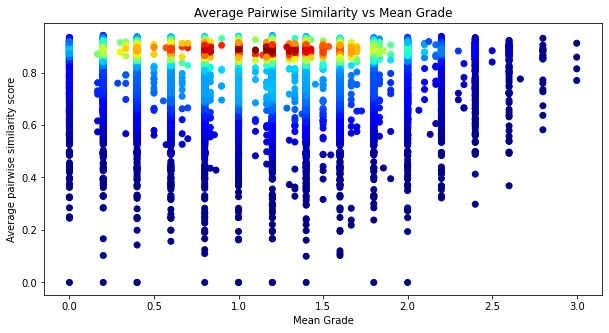

In [ ]:
similarity_scores = list(train_df['similarity score'])
mean_grades =  list(train_df['meanGrade'])

samples = mean_grades, similarity_scores

#calculate kernel:
densObj = kde(samples)

def makeColours( vals ):
    colours = np.zeros( (len(vals),3) )
    norm = Normalize( vmin=vals.min(), vmax=vals.max() )

    #Can put any colormap you like here.
    colours = [cm.ScalarMappable( norm=norm, cmap='jet').to_rgba( val ) for val in vals]

    return colours

colours = makeColours(densObj.evaluate(samples))
plt.figure(figsize=(10,5))
plt.title('Average Pairwise Similarity vs Mean Grade')
plt.xlabel('Mean Grade')
plt.ylabel('Average pairwise similarity score')
plt.scatter( samples[0], samples[1], color=colours)
plt.show()

In [ ]:
# Ion: Feeding a regression model with sentence represented just by their similarity scores

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

x_y = []
for idx, x_datum in enumerate(similarity_scores):
  x_y.append([x_datum, mean_grades[idx]])
train_proportion = 0.8
train_examples = round(len(similarity_scores)*train_proportion)
dev_examples = len(similarity_scores) - train_examples

x_y_train, x_y_test_here = random_split(x_y, (train_examples, dev_examples))
x_y_train = np.array(x_y_train)
x_y_test_here = np.array(x_y_test_here)

x_train = x_y_train[:, 0]
y_train = x_y_train[:, 1]
x_val = x_y_test_here[:, 0]
y_val = x_y_test_here[:, 1]

# create matrix versions of these arrays
X_train = x_train[:, np.newaxis]
X_val = x_val[:, np.newaxis]


for degree in [1, 2, 3, 100]:
    # Ion: Creating and fitting a polynomial regression of appropriate degree to the data
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    model.fit(X_train, y_train)
    print("Created model of degree {}".format(degree))

    # Ion: Making a prediction of mean funniness grades on the training data from the trained model
    predicted_y_train = model.predict(X_train)
    print("\nTrain performance:")
    sse, mse = model_performance(predicted_y_train, y_train, True)
    
    # Ion: Making a prediction of mean funniness grades on the validation data from the trained model
    predicted_y_val = model.predict(X_val)
    print("\nDev performance:")
    sse, mse = model_performance(predicted_y_val, y_val, True)
    print()


Created model of degree 1

Train performance:
| MSE: 0.36 | RMSE: 0.60 |

Dev performance:
| MSE: 0.35 | RMSE: 0.59 |

Created model of degree 2

Train performance:
| MSE: 0.36 | RMSE: 0.60 |

Dev performance:
| MSE: 0.35 | RMSE: 0.59 |

Created model of degree 3

Train performance:
| MSE: 0.36 | RMSE: 0.60 |

Dev performance:
| MSE: 0.35 | RMSE: 0.59 |

Created model of degree 100

Train performance:
| MSE: 0.36 | RMSE: 0.60 |

Dev performance:
| MSE: 0.35 | RMSE: 0.59 |



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


['france', 'paris', 'man', 'woman', 'queen', 'king', 'dog', 'obama', 'clinton', 'trump', 'republicans', 'democrats', 'run']
['walking', 'walked', 'running', 'ran', 'talking', 'talked', 'carrying', 'carried']
['man', 'woman', 'queen', 'king']


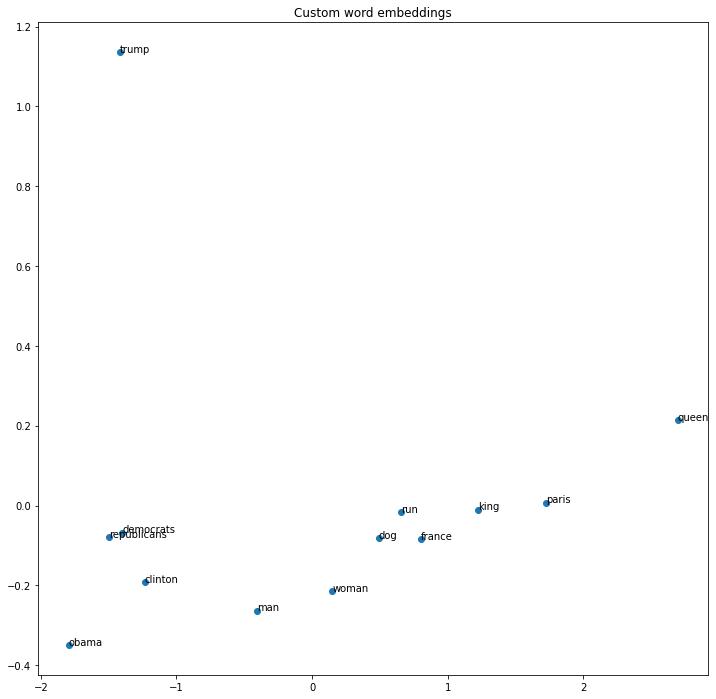

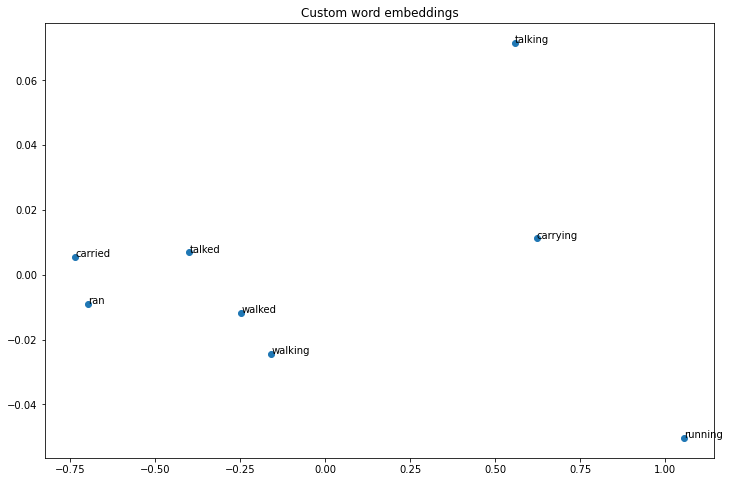

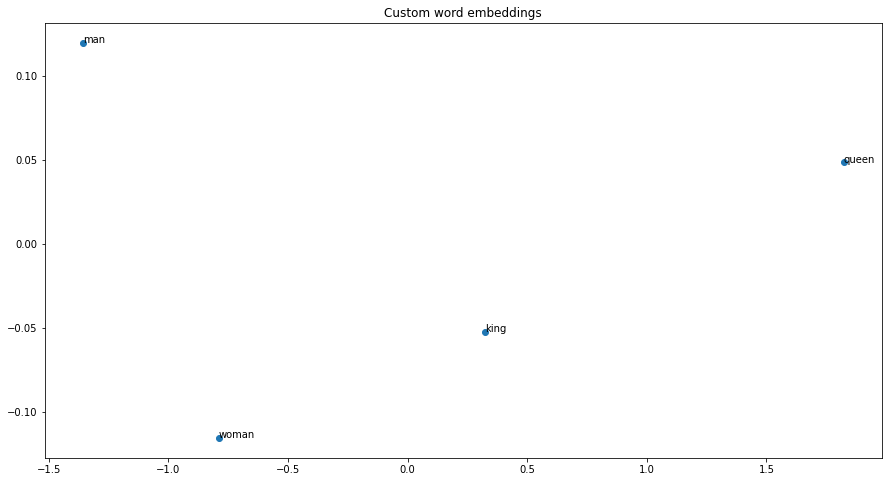

In [ ]:
################################################################################
#Exploring Embedding
################################################################################
from matplotlib import pyplot

keys_to_extract = ["france", 'paris',
                   'man','woman','queen','king', 'dog',
                  'obama', 'clinton', 'trump',
                  'republicans', 'democrats','run']

a_subset = {key: W2V.wv.vocab[key] for key in keys_to_extract}

early_words = list(W2V.wv.vocab)


X = W2V[a_subset]

pca = PCA(n_components=2)
result = pca.fit_transform(X)
fig, ax = pyplot.subplots(figsize=(8, 12))
ax.set_title('Custom word embeddings')
fig.set_figheight(12)
fig.set_figwidth(12)
pyplot.scatter(result[:, 0], result[:, 1])

words = list(a_subset)

print(words)

for i, word in enumerate(words):
  pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
#pyplot.figure(figsize=(30,30))
#fig= pyplot.figure(figsize=(6,3))
#pyplot.plot()
#pyplot.show()





keys_to_extract = ['walking', 'walked', 'running', 'ran', 'talking', 'talked', 'carrying', 'carried']
                  
a_subset = {key: W2V.wv.vocab[key] for key in keys_to_extract}

early_words = list(W2V.wv.vocab)


X = W2V[a_subset]

pca = PCA(n_components=2)
result = pca.fit_transform(X)
fig, ax = pyplot.subplots(figsize=(18, 12))
ax.set_title('Custom word embeddings')
fig.set_figheight(8)
fig.set_figwidth(12)
pyplot.scatter(result[:, 0], result[:, 1])

words = list(a_subset)

print(words)

for i, word in enumerate(words):
  pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
#pyplot.figure(figsize=(30,30))
#fig= pyplot.figure(figsize=(6,3))
#pyplot.plot()
#pyplot.show()



'man','woman','queen','king','girl', 'boy'



keys_to_extract = ['man','woman','queen','king']
                  
a_subset = {key: W2V.wv.vocab[key] for key in keys_to_extract}

early_words = list(W2V.wv.vocab)


X = W2V[a_subset]

pca = PCA(n_components=2)
result = pca.fit_transform(X)
fig, ax = pyplot.subplots(figsize=(18, 12))
ax.set_title('Custom word embeddings')
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.scatter(result[:, 0], result[:, 1])

words = list(a_subset)

print(words)

for i, word in enumerate(words):
  pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
#pyplot.figure(figsize=(30,30))
#fig= pyplot.figure(figsize=(6,3))
#pyplot.plot()
#pyplot.show()



In [ ]:
# Ion: Keeping track of unkown words we are replacing
unknowns_replaced_t = set()
test_unknowns_replaced_t = set()

# Ion: Our new training tokenised corpus where unkown words are replaced by '<unk>'
training_tokenized_corpus_unkowns_identified_t = []
test_tokenized_corpus_unkowns_identified_t = []

for seq in training_tokenized_corpus_t:
  seq_unkowns_identified_t = []
  for token in seq:
    if token not in word2idx_t:
      seq_unkowns_identified_t.append("<unk>")
      unknowns_replaced_t.add(token)
    else:
      seq_unkowns_identified_t.append(token)
  training_tokenized_corpus_unkowns_identified_t.append(seq_unkowns_identified_t)



for seq in test_tokenized_corpus_t:
  seq_unkowns_identified_t = []
  for token in seq:
    if token not in word2idx_t:
      seq_unkowns_identified_t.append("<unk>")
      test_unknowns_replaced_t.add(token)
    else:
      seq_unkowns_identified_t.append(token)
  test_tokenized_corpus_unkowns_identified_t.append(seq_unkowns_identified_t)



##############################################################################
# Ion: Representing headlines as lists of indices of tokens
vectorized_seqs_t = [[word2idx_t[tok] for tok in seq if tok in word2idx_t] for seq in training_tokenized_corpus_unkowns_identified_t]
# To avoid any sentences being empty (if no words match to our word embeddings)
vectorized_seqs_t = [x if len(x) > 0 else [0] for x in vectorized_seqs_t]
###############################################################################

##############################################################################
# Ion: Representing headlines as lists of indices of tokens
test_vectorized_seqs_t = [[word2idx_t[tok] for tok in seq if tok in word2idx_t] for seq in test_tokenized_corpus_unkowns_identified_t]
# To avoid any sentences being empty (if no words match to our word embeddings)
test_vectorized_seqs_t = [x if len(x) > 0 else [0] for x in test_vectorized_seqs_t]
###############################################################################

In [ ]:
print(torch.from_numpy(wvecs_t).size())
print(len(test_vectorized_seqs_t))

torch.Size([9799, 100])
2419


In [ ]:

def eval_hyperparam_combination_test_and_train_t(EMBEDDING_DIM, INPUT_DIM, BATCH_SIZE, feature, embedding, epochs, LR, print_on=True):
  model = BiLSTM(EMBEDDING_DIM, 50, INPUT_DIM, BATCH_SIZE, device)
  if print_on:
    print("BiLSTM Model initialised using custom Word2Vec Embeddings.")

  model.to(device)
  # We provide the model with our embeddings from glove
  model.embedding.weight.data.copy_(torch.from_numpy(embedding))



  # Ion: organise together TRAINING samples and their labels into an object instance of custom-made class Task1Dataset
  # 'feature' is a list of lists, each containing embedding IDs for word tokens
  train_and_dev = Task1Dataset(feature, train_df['meanGrade'])

  # Ion: Split the previously declared training samples further into training set and dev set for 
  #      preliminary experiments, as recommended.
  train_examples = round(len(train_and_dev)*train_proportion)
  dev_examples = len(train_and_dev) - train_examples
  train_dataset, dev_dataset = random_split(train_and_dev,
                                            (train_examples,
                                              dev_examples))

  train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
  dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_padd)
  if print_on:
    print("Dataloaders created.")

  loss_fn = nn.MSELoss()
  loss_fn = loss_fn.to(device)

  optimizer = torch.optim.Adam(model.parameters())

  final_epoch_rmse = train(train_loader, dev_loader, model, epochs, optimizer, loss_fn, print_on)
  if print_on:
    print(150*"-")


  
  labels = torch.zeros((len(test_vectorized_seqs_t), 1))

  features = test_vectorized_seqs_t

  test_dataset = Task1Dataset(features, labels)

  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 1, collate_fn=collate_fn_padd)
  if print_on:
    print("Test Dataloader created.")

  model.eval()
  
  pred_all = []
  no_observations = 0

  with torch.no_grad():
      for batch in test_loader:
          feature, label = batch 
          feature, label = feature.to(device), label.to(device)

          # for RNN:
          model.batch_size = label.shape[0]
          no_observations = no_observations + label.shape[0]
          model.hidden = model.init_hidden()

          predictions = model(feature).squeeze(1)
          pred_all.append(predictions.item())
          

  print(pred_all)
  
  return final_epoch_rmse, pred_all

In [ ]:
# Ion: To just train the model once run this cell
INPUT_DIM = len(word2idx_t)
EMBEDDING_DIM =100
feature = vectorized_seqs_t
embedding = wvecs_t
BATCH_SIZE = 46  # originally 32
LR = 0.00387
epochs = 18  #originally 10

final_epoch_rmse, pred_all = eval_hyperparam_combination_test_and_train_t(EMBEDDING_DIM, INPUT_DIM, BATCH_SIZE, feature, embedding,  epochs, LR)

BiLSTM Model initialised using custom Word2Vec Embeddings.
Dataloaders created.
Training model.
| Epoch: 01 | Train Loss: 0.42 | Train MSE: 0.42 | Train RMSE: 0.65 |           Val. Loss: 0.36 | Val. MSE: 0.36 |  Val. RMSE: 0.60 |
| Epoch: 02 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |           Val. Loss: 0.36 | Val. MSE: 0.36 |  Val. RMSE: 0.60 |
| Epoch: 03 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |           Val. Loss: 0.36 | Val. MSE: 0.36 |  Val. RMSE: 0.60 |
| Epoch: 04 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |           Val. Loss: 0.36 | Val. MSE: 0.36 |  Val. RMSE: 0.60 |
| Epoch: 05 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |           Val. Loss: 0.36 | Val. MSE: 0.36 |  Val. RMSE: 0.60 |
| Epoch: 06 | Train Loss: 0.36 | Train MSE: 0.36 | Train RMSE: 0.60 |           Val. Loss: 0.36 | Val. MSE: 0.36 |  Val. RMSE: 0.60 |
| Epoch: 07 | Train Loss: 0.35 | Train MSE: 0.35 | Train RMSE: 0.60 |           Val. Loss: 0.36 | Va

In [ ]:
print(len(pred_all))
print(final_epoch_rmse)

2419
0.5985639368828543


In [ ]:
# Ion: Inspecting the DataLoaders:

it = iter(train_loader)

num_batches_to_print = 1
batch_idx = 0

while batch_idx < num_batches_to_print:
  batch_of_inputs, batch_of_targets = next(it)

  print("Batch of Inputs:")
  print()
  print(batch_of_inputs)
  print()
  print("type: ", type(batch_of_inputs))
  print("shape = ", batch_of_inputs.shape)
  print(100*"-")
  print()

  print("Batch of Targets:")
  print()
  print(batch_of_targets)
  print()
  print("type: ", type(batch_of_targets))
  print("shape = ", batch_of_targets.shape)
  print(100*"-")
  print()

  batch_idx += 1

Batch of Inputs:

tensor([[    1, 13550,     8,  ...,     0,     0,     0],
        [ 7282,   668,  1801,  ...,     0,     0,     0],
        [    1,    39,   181,  ...,     0,     0,     0],
        ...,
        [  369,   942,     8,  ...,     0,     0,     0],
        [ 7282,   113,   559,  ...,     0,     0,     0],
        [ 7282,  2760,  4504,  ...,     0,     0,     0]])

type:  <class 'torch.Tensor'>
shape =  torch.Size([73, 18])
----------------------------------------------------------------------------------------------------

Batch of Targets:

tensor([0.8000, 1.6000, 1.4000, 2.0000, 0.2000, 1.6000, 0.0000, 2.2000, 1.8000,
        1.4000, 0.4000, 1.6667, 1.5000, 1.0000, 1.6000, 1.4000, 0.6000, 1.0000,
        2.0000, 1.0000, 1.6000, 1.2000, 0.0000, 1.2000, 1.6000, 2.0000, 0.2000,
        1.2000, 1.6000, 0.4000, 0.6000, 0.6000, 0.8000, 0.2000, 0.6000, 1.6000,
        1.2000, 1.2000, 0.0000, 1.8000, 0.6000, 1.8000, 1.0000, 1.2000, 1.0000,
        1.2000, 1.6000, 1.6000, 1.2000

In [ ]:
################################################################################
# COMMENTED CELLS CORRESPOND TO W2V MANUAL IMPLEMENTATION
# THIS IMPLEMENTATION WAS ONLY USED ONCE BUT DISCARDED DUE TO LONG
# TRAINING TIME
################################################################################

# implement word embeddings from scratch

# from numpy.random import multinomial

# def sample_negative(sample_size):
#     sample_probability = {}
#     word_counts = dict(Counter(list(itertools.chain.from_iterable(joint_tokenized_corpus))))
#     normalizing_factor = sum([v**0.75 for v in word_counts.values()])
#     for word in word_counts:
#         sample_probability[word] = word_counts[word]**0.75 / normalizing_factor
#     words = np.array(list(word_counts.keys()))
#     while True:
#         word_list = []
#         sampled_index = np.array(multinomial(sample_size, list(sample_probability.values())))
#         for index, count in enumerate(sampled_index):
#             for _ in range(count):
#                  word_list.append(words[index])
#         yield word_list

In [ ]:
# import numpy as np
# from collections import Counter
# import random, math
# import itertools


# context_tuple_list = []
# w = 4
# negative_samples = sample_negative(8)
# counter = 0
# print(len(joint_tokenized_corpus))
# for text in joint_tokenized_corpus:
#     counter +=1
#     print(counter/len(joint_tokenized_corpus) *100)
#     for i, word in enumerate(text):
#         first_context_word_index = max(0,i-w)
#         last_context_word_index = min(i+w, len(text))
#         for j in range(first_context_word_index, last_context_word_index):
#             if i!=j:
#                 context_tuple_list.append((word, text[j], next(negative_samples)))
    
# print("There are {} pairs of target and context words".format(len(context_tuple_list)))


In [ ]:
# import torch
# import torch.nn  as  nn
# import torch.autograd  as autograd
# import torch.optim as optim
# import torch.nn.functional as F


# class Word2Vec(nn.Module):

#     def __init__(self, embedding_size, vocab_size):
#         super(Word2Vec, self).__init__()
#         self.embeddings_target = nn.Embedding(vocab_size, embedding_size)
#         self.embeddings_context = nn.Embedding(vocab_size, embedding_size)

#     def forward(self, target_word, context_word, negative_example):
#         emb_target = self.embeddings_target(target_word)
#         emb_context = self.embeddings_context(context_word)
#         emb_product = torch.mul(emb_target, emb_context)
#         emb_product = torch.sum(emb_product, dim=1)
#         out = torch.sum(F.logsigmoid(emb_product))
#         emb_negative = self.embeddings_context(negative_example)
#         emb_product = torch.bmm(emb_negative, emb_target.unsqueeze(2))
#         emb_product = torch.sum(emb_product, dim=1)
#         out += torch.sum(F.logsigmoid(-emb_product))
#         return -out


In [ ]:
# class EarlyStopping():
#     def __init__(self, patience=5, min_percent_gain=0.1):
#         self.patience = patience
#         self.loss_list = []
#         self.min_percent_gain = min_percent_gain / 100.
        
#     def update_loss(self, loss):
#         self.loss_list.append(loss)
#         if len(self.loss_list) > self.patience:
#             del self.loss_list[0]
    
#     def stop_training(self):
#         if len(self.loss_list) == 1:
#             return False
#         gain = (max(self.loss_list) - min(self.loss_list)) / max(self.loss_list)
#         print("Loss gain: {}%".format(round(100*gain,2)))
#         if gain < self.min_percent_gain:
#             return True
#         else:
#             return False

In [ ]:
# import random

# def get_batches(context_tuple_list, batch_size=100):
#     random.shuffle(context_tuple_list)
#     batches = []
#     batch_target, batch_context, batch_negative = [], [], []
#     for i in range(len(context_tuple_list)):
#         batch_target.append(word_to_index[context_tuple_list[i][0]])
#         batch_context.append(word_to_index[context_tuple_list[i][1]])
#         batch_negative.append([word_to_index[w] for w in context_tuple_list[i][2]])
#         if (i+1) % batch_size == 0 or i == len(context_tuple_list)-1:
#             tensor_target = autograd.Variable(torch.from_numpy(np.array(batch_target)).long())
#             tensor_context = autograd.Variable(torch.from_numpy(np.array(batch_context)).long())
#             tensor_negative = autograd.Variable(torch.from_numpy(np.array(batch_negative)).long())
#             batches.append((tensor_target, tensor_context, tensor_negative))
#             batch_target, batch_context, batch_negative = [], [], []
#     return batches

In [ ]:
# word_to_index = {w: idx for (idx, w) in enumerate(joint_vocab)}
# index_to_word = {idx: w for (idx, w) in enumerate(joint_vocab)}

# print(context_tuple_list[0:100])

In [ ]:
# import time

# vocabulary_size = len(joint_vocab)

# loss_function = nn.CrossEntropyLoss()
# net = Word2Vec(embedding_size=200, vocab_size=vocabulary_size)
# optimizer = optim.Adam(net.parameters())
# early_stopping = EarlyStopping(patience=5, min_percent_gain=1)

# while True:
#     losses = []
#     context_tuple_batches = get_batches(context_tuple_list, batch_size=2000)
#     for i in range(len(context_tuple_batches)):
#         net.zero_grad()
#         target_tensor, context_tensor, negative_tensor = context_tuple_batches[i]
#         loss = net(target_tensor, context_tensor, negative_tensor)
#         loss.backward()
#         optimizer.step()
#         losses.append(loss.data)
#     print("Loss: ", np.mean(losses))
#     early_stopping.update_loss(np.mean(losses))
#     if early_stopping.stop_training():
#         break

In [ ]:
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader
# from torch.utils.data import sampler

# torch.jit.save(torch.jit.trace(net, (optimizer)), '/content/drive/MyDrive/NLP_WE_Model.pth')

In [ ]:
# import numpy as np

# def get_closest_word(word, topn=5):
#     word_distance = []
#     emb = net.embeddings_target
#     pdist = nn.PairwiseDistance()
#     i = word_to_index[word]
#     lookup_tensor_i = torch.tensor([i], dtype=torch.long)
#     v_i = emb(lookup_tensor_i)
#     for j in range(len(vocabulary)):
#         if j != i:
#             lookup_tensor_j = torch.tensor([j], dtype=torch.long)
#             v_j = emb(lookup_tensor_j)
#             word_distance.append((index_to_word[j], float(pdist(v_i, v_j))))
#     word_distance.sort(key=lambda x: x[1])
#     return word_distance[:topn]

In [ ]:
# import pickle

# with open("WE_wednesday.txt", "wb") as fp:   #Pickling
#     pickle.dump(context_tuple_list, fp)

In [ ]:
train_and_dev = train_df['edit']

training_data, dev_data, training_y, dev_y = train_test_split(train_df['edit'], train_df['meanGrade'],
                                                                        test_size=(1-train_proportion),
                                                                        random_state=42)

# We train a Tf-idf model
count_vect = CountVectorizer(stop_words='english')
train_counts = count_vect.fit_transform(training_data)
transformer = TfidfTransformer().fit(train_counts)
train_counts = transformer.transform(train_counts)
regression_model = LinearRegression().fit(train_counts, training_y)

# Train predictions
predicted_train = regression_model.predict(train_counts)

# Calculate Tf-idf using train and dev, and validate model on dev:
test_and_test_counts = count_vect.transform(train_and_dev)
transformer = TfidfTransformer().fit(test_and_test_counts)

test_counts = count_vect.transform(dev_data)

test_counts = transformer.transform(test_counts)

# Dev predictions
predicted = regression_model.predict(test_counts)

# We run the evaluation:
print("\nTrain performance:")
sse, mse = model_performance(predicted_train, training_y, True)

print("\nDev performance:")
sse, mse = model_performance(predicted, dev_y, True)

  (0, 1397)	1.0
  (1, 3944)	1.0
  (2, 428)	1.0
  (3, 5814)	1.0
  (4, 1726)	1.0
  (5, 5764)	1.0
  (6, 6010)	1.0
  (8, 2869)	1.0
  (9, 622)	1.0
  (10, 1210)	1.0
  (11, 655)	1.0
  (12, 1721)	1.0
  (13, 4491)	1.0
  (14, 749)	1.0
  (15, 4865)	1.0
  (16, 3828)	1.0
  (17, 1945)	1.0
  (18, 4370)	1.0
  (19, 2382)	1.0
  (20, 3249)	1.0
  (21, 1652)	1.0
  (22, 802)	1.0
  (23, 3990)	1.0
  (24, 1766)	1.0
  (25, 4360)	1.0
  :	:
  (14295, 652)	1.0
  (14296, 1178)	1.0
  (14297, 311)	1.0
  (14298, 1491)	1.0
  (14299, 3702)	1.0
  (14300, 1701)	1.0
  (14301, 5486)	1.0
  (14302, 5717)	1.0
  (14303, 3219)	1.0
  (14304, 1380)	1.0
  (14305, 1699)	1.0
  (14306, 336)	1.0
  (14307, 4006)	1.0
  (14308, 5264)	1.0
  (14309, 4519)	1.0
  (14310, 1270)	1.0
  (14311, 5493)	1.0
  (14312, 4358)	1.0
  (14313, 3933)	1.0
  (14314, 2574)	1.0
  (14315, 1401)	1.0
  (14316, 2550)	1.0
  (14317, 6105)	1.0
  (14318, 1995)	1.0
  (14319, 4263)	1.0

Train performance:
| MSE: 0.16 | RMSE: 0.40 |

Dev performance:
| MSE: 0.37 | RMSE: 0

#### Baseline for task 2

In [ ]:
# Baseline for the task
pred_baseline = torch.zeros(len(dev_y)) + np.mean(training_y)
print("\nBaseline performance:")
sse, mse = model_performance(pred_baseline, dev_y, True)


Baseline performance:
| MSE: 0.36 | RMSE: 0.60 |


In [ ]:
#Nik: import nltk library, used for POS tagging
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from collections import Counter


print(train_df['original'])
#Nik: Add extra column to dataframe. This will be filled with max occurance of POS
train_df['most_common'] = np.nan

#Loop through original training corpus, create (word, POS) pairs:

for row, sentence in enumerate(train_df['original']):
  tokens = nltk.word_tokenize(sentence)
  tags = nltk.pos_tag(tokens)
  #Create count of tags dictionary:
  tag_dict = Counter(elem[1] for elem in tags)
  #First tag is the most common since dictionary is sorted:
  most_common = list(tag_dict.keys())[0]
  #Add most common POS to new column
  train_df['most_common'][row] = most_common

#Repeat the same for the test set:
for row, sentence in enumerate(test_df['original']):
  tokens = nltk.word_tokenize(sentence)
  tags = nltk.pos_tag(tokens)
  tag_dict = Counter(elem[1] for elem in tags)
  most_common = list(tag_dict.keys())[0]
  train_df['most_common'][row] = most_common


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
0        France is ‘ hunting down its citizens who join...
1        Pentagon claims 2,000 % increase in Russian tr...
2        Iceland PM Calls Snap Vote as Pedophile Furor ...
3        In an apparent first , Iran and Israel <engage...
4        Trump was told weeks ago that Flynn misled <Vi...
                               ...                        
17895    Banning Facial <Recognition/> Is n’t Enough - ...
17896    Trump is reportedly threatening <Republicans/>...
17897    Peruvian indigenous group wins suit to block o...
17898    Joe Rogan says he 's probably voting for <Bern...
17899    While Microsoft Was Making Its Climate Pledge ...
Name: original, Length: 17900, dtype: object


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
print(train_df)
print(test_df)

           id                                           original        edit  \
0       14530  France is ‘ hunting down its citizens who join...       twins   
1       13034  Pentagon claims 2,000 % increase in Russian tr...     bowling   
2        8731  Iceland PM Calls Snap Vote as Pedophile Furor ...       party   
3          76  In an apparent first , Iran and Israel <engage...        slap   
4        6164  Trump was told weeks ago that Flynn misled <Vi...      school   
...       ...                                                ...         ...   
17895  108243  Banning Facial <Recognition/> Is n’t Enough - ...   Cleansers   
17896  108244  Trump is reportedly threatening <Republicans/>...    children   
17897  108245  Peruvian indigenous group wins suit to block o...       Women   
17898  108246  Joe Rogan says he 's probably voting for <Bern...  Illuminati   
17899  108247  While Microsoft Was Making Its Climate Pledge ...       Spill   

       grades  meanGrade             ol

In [ ]:
#Repeat regression process of part 2, using POS instead of word vecs:
#Use tag column as our training data
train_and_dev = train_df['most_common']

#Train_y remains as it is (targets are the scores)
training_data, dev_data, training_y, dev_y = train_test_split(train_df['most_common'], train_df['meanGrade'],
                                                                        test_size=(1-train_proportion),
                                                                        random_state=42)

# We train a Tf-idf model
count_vect = CountVectorizer(stop_words='english')

train_counts = count_vect.fit_transform(training_data)

transformer = TfidfTransformer().fit(train_counts)
train_counts = transformer.transform(train_counts)


regression_model = LinearRegression().fit(train_counts, training_y)

# Train predictions
predicted_train = regression_model.predict(train_counts)

# Calculate Tf-idf using train and dev, and validate model on dev:
test_and_test_counts = count_vect.transform(train_and_dev)
transformer = TfidfTransformer().fit(test_and_test_counts)

test_counts = count_vect.transform(dev_data)

test_counts = transformer.transform(test_counts)

# Dev predictions
predicted = regression_model.predict(test_counts)

# We run the evaluation:
print("\nTrain performance:")
sse, mse = model_performance(predicted_train, training_y, True)

print("\nDev performance:")
sse, mse = model_performance(predicted, dev_y, True)


Train performance:
| MSE: 0.35 | RMSE: 0.59 |

Dev performance:
| MSE: 0.37 | RMSE: 0.60 |
